## Understanding LLaMA 3: An In-Depth Look

LLaMA 3 is the latest iteration in the LLaMA (Large Language Model Architecture) series, building upon its predecessor, LLaMA 2. This advanced architecture is almost same as llama2 except the incorporation of Grouped Multi Query Attention in its smaller models, such as the 8B and 8B-chat variants.

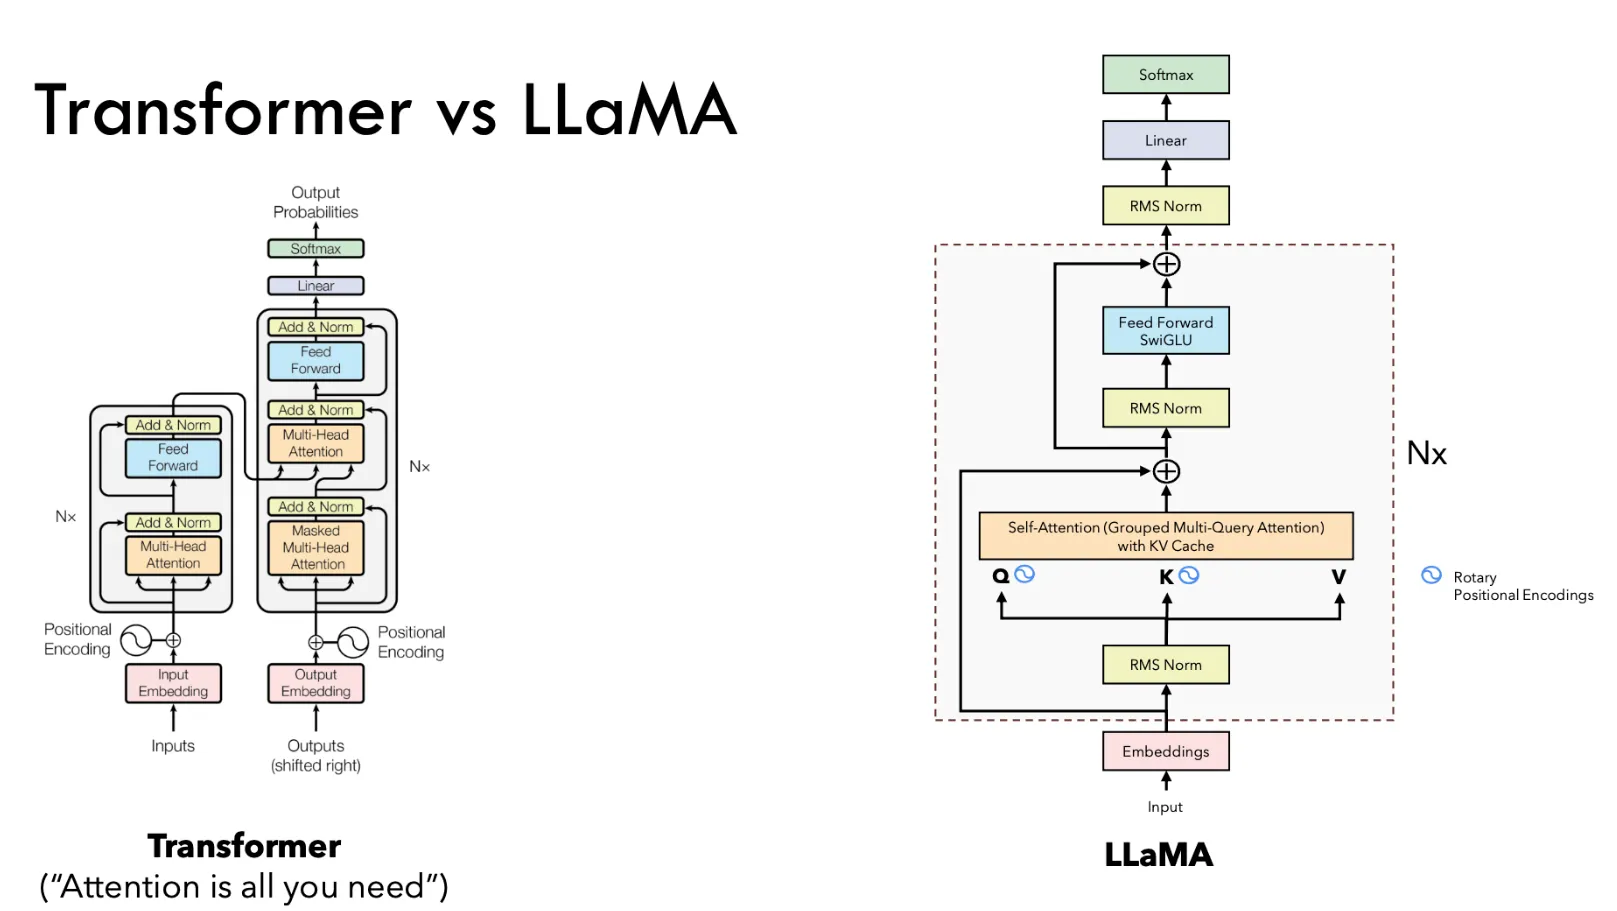

*Image courtesy of [Umar Jamil AI's YouTube Channel](https://www.youtube.com/@umarjamilai)*

Below, we delve into the critical components that constitute the LLaMA 3 architecture:

1. **RMS Norm Layer**: This layer applies Root Mean Square Layer Normalization, which is a variant of layer normalization that stabilizes the neural network's internal state by normalizing the input of each layer.

2. **Rotary Positional Embeddings**: These embeddings are a novel approach to incorporating positional information into the attention mechanism, allowing the model to maintain the relative ordering of input tokens effectively, instead of absolute ordering

3. **KV Cache**: The Key-Value cache is a mechanism designed to reduce redundant computations, particularly in the context of processing sequences. It stores previously computed key and value vectors, which can be reused in subsequent attention calculations.

4. **Grouped Multi Query Attention**: An attention mechanism that groups queries together to process multiple queries simultaneously, leading to efficiency gains in computation without compromising the model's performance.

5. **SwiGLU Feed Forward Layer**: The SwiGLU (Gated Linear Unit with Sigmoid and Weighted Linear Units) is a type of feed-forward neural network layer that enhances the model's ability to capture complex patterns by applying non-linear transformations.

In the following sections, we will explore each of these components in detail and guide you through the process of implementing these layers to harness the full potential of the LLaMA 3 architecture. Whether you're looking to understand the theoretical underpinnings or apply these concepts in practice, this comprehensive breakdown will provide you with the insights needed to work with this cutting-edge language model.

In [628]:
#let's import all the necessary libraries
import torch
import math
from dataclasses import dataclass
from typing import Optional, Tuple
from torch import nn
import torch.nn.functional as F

#let's define the Model arguments
@dataclass
class ModelArgs:
    dim: int = 4096 # embedding dimension
    n_layers: int = 32 # no of transformer layers
    n_heads: int = 32 # no of attention heads
    n_kv_heads: Optional[int] = None # no of key value heads, used in GQA
    vocab_size: int = -1 # vocab size
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None # used in SwiGLU
    norm_eps: float = 1e-5 # layer norm epsilon
    rope_theta: float = 500000 # theta used in RoPE

    max_batch_size: int = 32 # max batch size
    max_seq_len: int = 2048 # max sequence length

## RMS Norm Layer

The LLaMa 3 architecture leverages RMSNorm (Root Mean Square Layer Normalization) instead of LayerNorm to achieve significant computational efficiency without sacrificing performance. This approach builds upon the success of LayerNorm in stabilizing deep neural network training but focuses on the core benefit: re-scaling invariance.

### Key Differences:
- **Scaling Only:** Unlike Layer Norm, which centers and scales the data, paper claims that that the re-scaling invariance is the reason for success of LayerNorm, rather than re-centering invariance.
- **Normalization:** RMS Norm uses the root mean square (RMS) of the activations in each layer to normalize their magnitude, ensuring they have a unit norm on average.
- **Learned Parameter:** It employs a learned parameter for scaling without centering the activations.

### Performance Benefits:
- **Efficiency:** Results indicate that RMS Norm achieves speedups ranging from 7% to 64% across different models due to its simpler calculations.

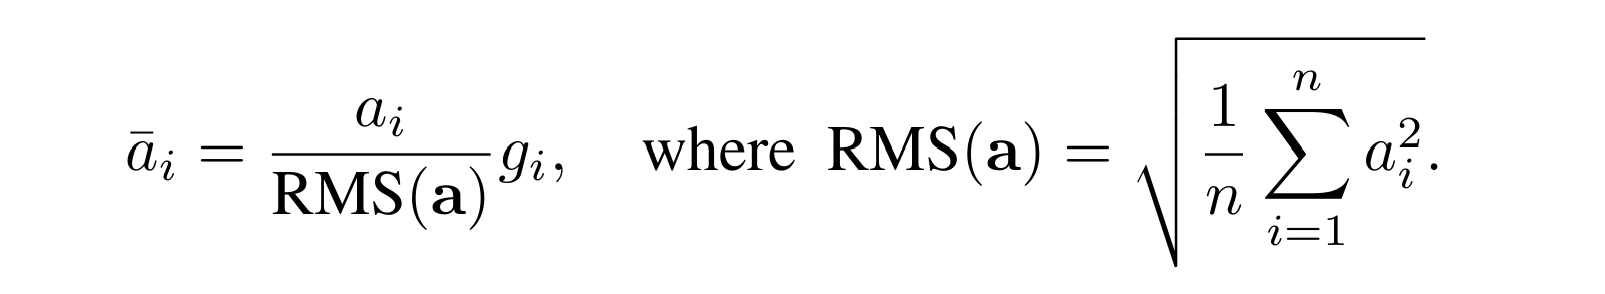

For more details, the full paper can be accessed at [arXiv:1910.07467](https://arxiv.org/pdf/1910.07467)


In [629]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps # used to avoid division by zero
        self.weight = torch.nn.Parameter(torch.ones(dim)) # learnable parameter for scaling
    
    def norm (self, x):
        inv_rms = torch.rsqrt(torch.mean(x.pow(2), dim=-1, keepdim=True) + self.eps) # calculate the inverse root mean square
        return x * inv_rms # normalize the input tensor
    
    def forward(self, x):
        return self.norm(x) * self.weight # scale the normalized tensor

## Rotary Positional Embeddings

The research paper titled ["ROFORMER"](https://arxiv.org/pdf/2104.09864v4) introduces a novel approach for integrating positional information into transformer-based language models. This technique, known as Rotary Positional Encoding (RoPE), leverages a rotation matrix to encode absolute positions and explicitly incorporates relative positional dependencies within the self-attention mechanism.

## Advantages of Rotary Positional Encoding (RoPE)

RoPE offers several advantages compared to traditional sinusoidal embeddings:

- **Adaptability to Variable Sequence Lengths**: RoPE can handle sequences of different lengths with ease.
- **Diminishing Inter-Token Dependency with Distance**: As the relative distance between tokens increases, the dependency between them decays, which is a desirable property for modeling long-range interactions.
- **Enabling Relative Position Encoding in Linear Self-Attention**: RoPE facilitates the use of relative position information in models with linearized self-attention mechanisms, instead of absolute positional encodings

The LLama 3 Model incorporates RoPE embeddings in lieu of sinusoidal embeddings, finding that RoPE provides superior performance as sequence lengths grow, and it inherently accounts for relative positions in self-attention calculations.

The computation of RoPE embeddings is depicted as follows:

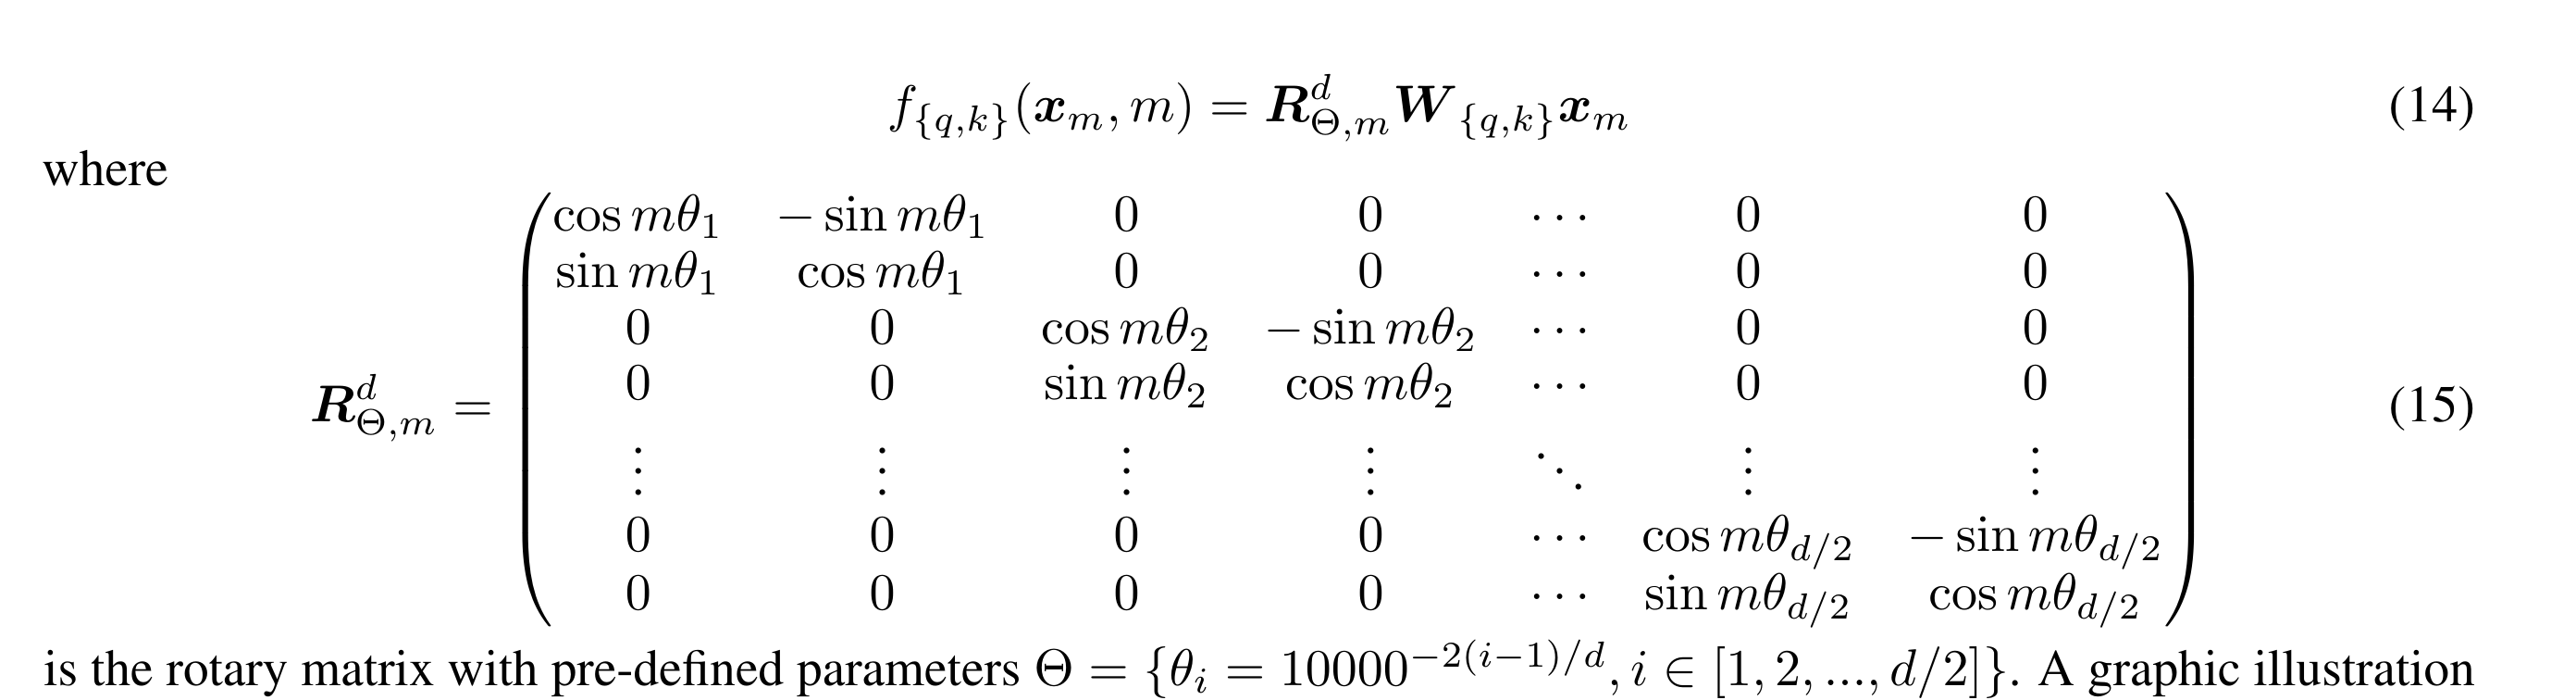

Here, `x` represents the input, `w` is the weight matrix for the key or query, and `R` is the rotary positional encoding matrix that encodes the position.

An efficient representation of the multiplication process is shown below:

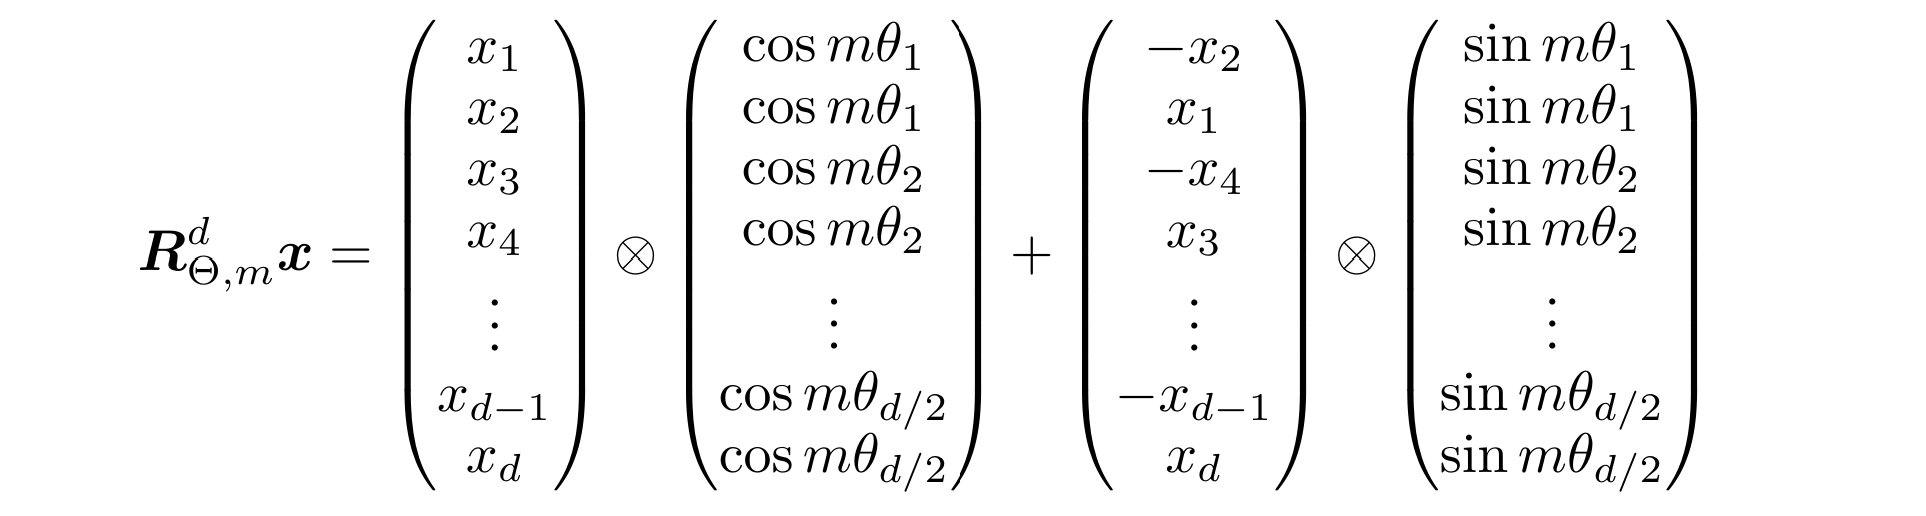

This can be achieved by series of steps

1. Pre Compute frequencies in polar form of type cosf + isinf for each possible position and dim
2. Spilt the input vector by taking grouping every 2 rows together (x1, x2, ... xdim) -> ([x1, x2], [x3, x4], [x5, x6] .... [xdim-1, xdim])
3. Covert the group to complex number ([x1 + ix2, x3 + ix4, x5 + ix6 ...])
4. Multiply the new complex tensor with corresponding row of freq tensor -> (x1cosf)
5. 

It is important to note that the cosine and sine matrices remain constant for a given `m`, allowing us to precompute these matrices for all positions up to the maximum sequence length (`1:max_seq_len`)

The calculation of RoPE embeddings involves two primary steps:

1. **Precomputation**: Calculate and store the cosine and sine vectors for all possible position lengths.
2. **Application**: 


For more details, the full paper can be accessed at [arXiv:2104.09864v4](https://arxiv.org/pdf/2104.09864v4).

### Pre Computation

Here we precomute frequencies for all values of dimensions and sequence length and finally store it in a polar form of R = |abs|e^(i*theta), wheere abs = 1



In [630]:
def precompute_freqs_cis(dim: int, seq_len: int, theta: float = 10000.0):

    dim_enumerations = torch.arange(0, dim, 2)[: (dim // 2)].float() # 0, 2, ... dim - 2

    # calculate the frequencies  (1/theta^(2(i-1)/dim)
    freqs = 1.0 / (theta ** dim_enumerations / dim)

    # get all possible values of positions (0, 1, ... seq_len - 1)
    t = torch.arange(seq_len, device=freqs.device, dtype=torch.float32)

    # now compute all possible values of the frequencies for all positions using the outer product (j*1/theta^(2(i-1)/dim) for all i and j)
    freqs = torch.outer(t, freqs)    # (Seq_len, 1) * (1, Dim//2) = (Seq_len, Dim//2)
    
    # convert the frequencies to complex numbers in polar form using 1* e^(i*freq) = cos(freq) + i*sin(freq)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)   
    return freqs_cis

### Apply the positional encodings

In [631]:
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    # (B, Seq, num_heads * head_dim) -> (B, Seq, num_heads, head_dim/2, 2)
    xq_ = xq.float().reshape(*xq.shape[:-1], -1, 2)
    xk_ = xk.float().reshape(*xk.shape[:-1], -1, 2)

    #Create complex number using the last dimension
    xq_ = torch.view_as_complex(xq_)     #(B, Seq, num_heads, head_dim/2, 2) -> (B, Seq, num_heads, head_dim/2)
    xk_ = torch.view_as_complex(xk_)


    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)     # (Seq, head_dim/2) -> (1, Seq, 1, head_dim/2)

    # Element-wise multiplication after broadcasting
    xq_out = xq_ * freqs_cis      # (B, Seq, num_heads, head_dim/2) * (1, Seq, 1, head_dim/2)  -> (B, Seq, num_heads, head_dim/2)
    xk_out = xk_ * freqs_cis

    # unwrap the complex number to real number
    xq_out = torch.view_as_real(xq_out)     # (B, Seq, num_heads, head_dim/2) -> (B, Seq, num_heads, head_dim/2, 2) 
    xk_out = torch.view_as_real(xk_out)

    xq_out = xq_out.reshape(*xq.shape)     # (B, Seq, num_heads, head_dim/2, 2) -> (B, Seq, num_heads * head_dim)
    xk_out = xk_out.reshape(*xk.shape)

    return xq_out.type_as(xq), xk_out.type_as(xk)

## KV Cache

KV Cache, or Key-Value Cache, is a technique designed to optimize the inference time of autoregressive models such as LLaMa and GPT. These models generate tokens sequentially, and with each new token, they require the computation of attention using all preceding tokens. This process often leads to redundant calculations.

### Enhancing Inference Efficiency

The illustration below demonstrates how attention is calculated for all tokens at each step. Since the previous tokens remain unchanged, it is unnecessary to recompute attention for them. Instead, we should focus solely on computing attention for the newly generated token.

![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*8xqD4AYTwn6mQXNw0uhDCg.gif)

### Caching Mechanism

To avoid these repetitive calculations, we implement KV caching. By storing the Keys and Values once they are computed at each step, we can concentrate on calculating attention only for the current token. This approach significantly reduces the number of computations needed, thereby enhancing the speed of token generation.

![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*uyuyOW1VBqmF5Gtv225XHQ.gif)

By leveraging the cached Keys and Values, we can drastically reduce the computational load and improve generation speeds.

*The images used in this explanation are credited to [João Lages](https://medium.com/@joaolages/kv-caching-explained-276520203249).*

### Initialization

```python
    # Initializing the KV cache tensors
    self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
    self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
```

### Updating the KV Cache
``` python
    # update the kv cache for the current sequence
    self.cache_k[:batch_size, start_pos:start_pos + seq_len] = xk
    self.cache_v[:batch_size, start_pos:start_pos + seq_len] = xv
```

### Fetching keys and values from KV Cache
``` python
    #get the cached kv pairs
    keys = self.cache_k[:batch_size, :start_pos + seq_len]
    values = self.cache_v[:batch_size, :start_pos + seq_len]
```

*Note: The above code is part of a Transformer block implementation.*

## Grouped Multi-Query Attention

### The Challenge with Traditional Multi-Head Attention
In the standard Transformer architecture, each attention head has its own set of keys, values, and queries. While this multi-head attention (MHA) mechanism allows the model to capture different types of information from different representation subspaces, it also means that during inference, the model must load all these keys and values into memory. Given that memory operations can be more expensive than computation on GPUs, this can bottleneck the inference process.

### Multi-Query Attention
To address this, one could use Multi-Query Attention (MQA), where multiple query heads share a single key and value head. This approach significantly reduces the memory bandwidth required during inference because only one set of key-value pairs is loaded. However, this simplification comes at the cost of reduced output quality, as the model's capacity to capture diverse information is diminished.

### Grouped-Query Attention
The novel solution proposed is Grouped-Query Attention (GQA), which strikes a balance between the efficiency of MQA and the representational power of MHA. In GQA, queries are grouped, and each group is assigned a single key and value head. This method reduces the memory footprint compared to MHA but maintains more capacity than MQA, leading to better output quality without significantly compromising inference speed.

### Visual Representation of GQA
The following diagram illustrates the concept of GQA, showing how query heads are grouped and associated with single key and value heads:

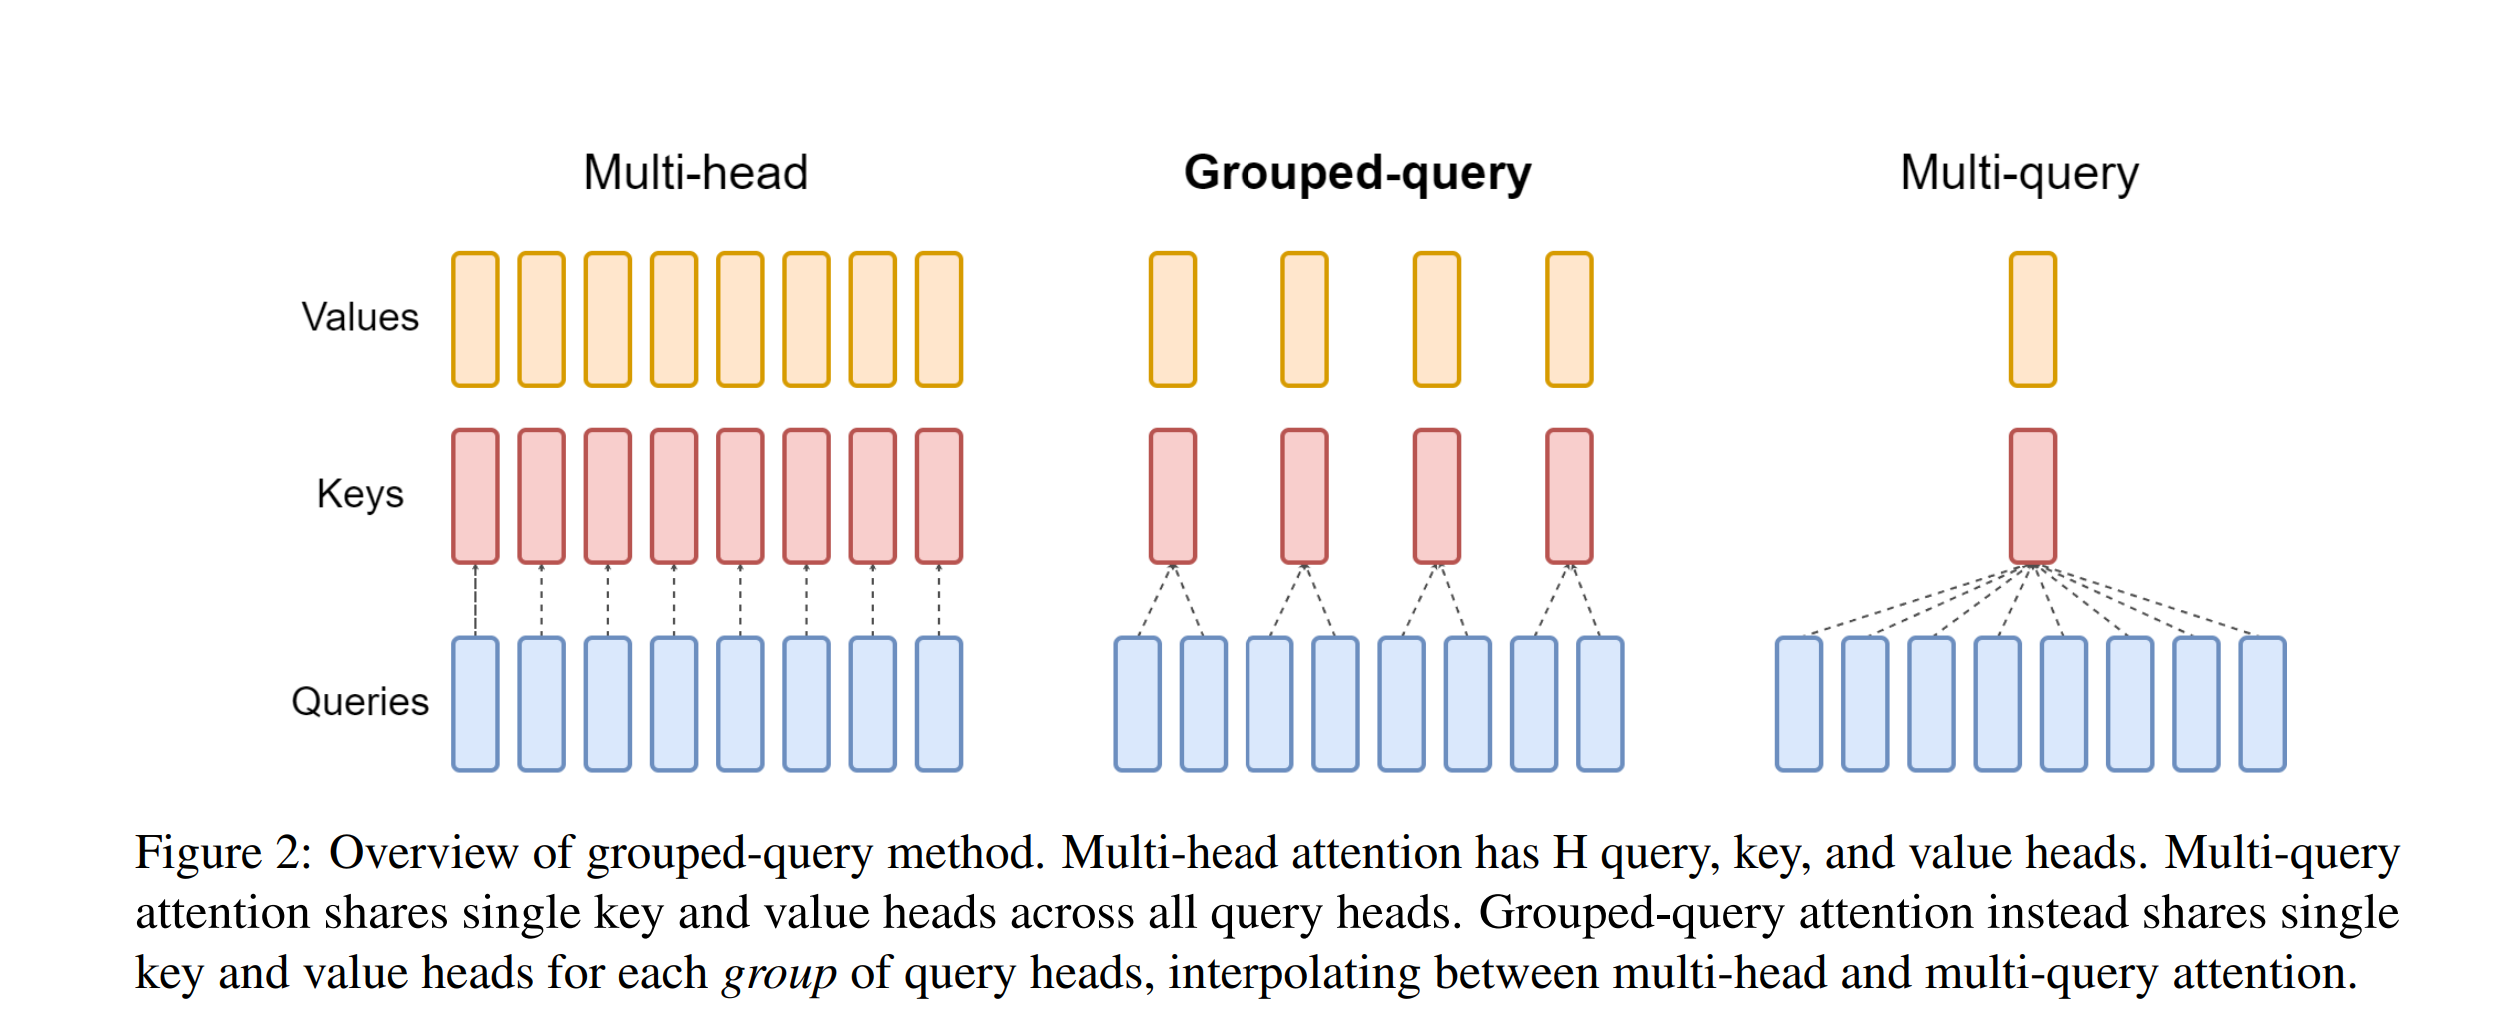

### Benefits of Grouped-Query Attention
- **Reduced Memory Bandwidth**: By grouping query heads and sharing key-value pairs, GQA lowers the memory bandwidth required during inference.
- **Quality Preservation**: Unlike MQA, which can degrade output quality, GQA maintains a level of quality closer to that of MHA.
- **Cost-Effective Uptraining**: Existing MHA models can be uptrained to GQA models using a fraction of the original pre-training compute, making this approach both efficient and economical.


For more details, the full paper can be accessed at [arXiv:2305.13245v3](https://arxiv.org/pdf/2305.13245v3).


### Initialization

```python
    # query heads 
    self.n_local_heads = args.n_heads
    # kv heads different from query heads used in GQA
    self.n_kv_heads = args.n_kv_heads if args.n_kv_heads is not None else self.n_local_heads 
    self.head_dim = args.dim // self.n_local_heads
    self.wk = torch.nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias = False)
    self.wv = torch.nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias = False)
    self.wq = torch.nn.Linear(args.dim, self.n_local_heads * self.head_dim, bias = False)
    self.wo = torch.nn.Linear(args.dim, self.n_local_heads * self.head_dim, bias = False)
    self.rep = self.n_local_heads // self.n_kv_heads
```

In the implementation, I did not fully implement the optimization, I just repeated the keys and values `rep` times to match number of queries grouped to it, then I applied usual self attention

In [632]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    '''Repeat the key and value tensors n_rep times along the last dimension.'''

    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :] #adding a extra dimension
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim) # expanding the dimension by repeating
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim) # reshaping the dimension
    )

### Usage

```python
    # copy and repeat the kv pairs to match query head count
    keys = repeat_kv(keys, self.rep) # (B, Seq_KV, n_kv_heads, head_dim) -> (B, Seq, n_heads, head_dim)
    values = repeat_kv(values, self.rep) # (B, Seq_KV, n_kv_heads, head_dim) -> (B, Seq, n_heads, head_dim)
```
*Note: The above code is part of a Transformer block implementation.*


## Attention Block

Now that we have understood all the necessary components, let's integrate all of them into one Attention Block:

1. **Linear Transformation for Key, Query, and Value Generation**:
   - Utilize separate linear layers to transform the input tensor into the key (k), query (q), and value (v) representations.
   - Since we're transforming the same input to get keys, queries, and values, this process is known as **Self-Attention**, which is a mechanism where the model focuses on and assesses the relationships within the same sequence.

2. **Multi-Head Splitting**:
   - Divide the keys, queries, and values into multiple heads, as we are using Grouped Query Attention(GQA) number of heads of queries will be different from number of heads of keys and values and multiple query heads map to single key/value head.
   - This multi-head configuration allows the model to capture information from different representation subspaces at different positions.

3. **Rotary Positional Encoding**:
   - Apply Rotary Positional Encoding (RoPE) to both keys and values to imbue them with positional context.

4. **Key-Value Cache Update**:
   - Update the Key-Value (KV) cache with the newly computed keys and values for subsequent attention operations and fetch the all keys and values to compute attention from the cache

5. **Repeat Keys and Values to match Query heads**:
   - Adjust the dimensions of the keys and values heads to match the query heads. This is done by repeating keys and values by the value of number of queries grouped to it.

6. **Self-Attention**:
   - Perform the self-attention operation using the processed queries, keys, and values as per the [Attention Is All You Need](https://arxiv.org/pdf/1706.03762) paper

7. **Output Linear Transformation**:
   - Conclude the AttentionBlock by applying a final linear layer to the output of the self-attention mechanism. This transformation consolidates the multi-head attention results into a single tensor, which represents the integrated information processed by the block.

In [633]:
class Attention(torch.nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_local_heads = args.n_heads
        self.n_kv_heads = args.n_kv_heads if args.n_kv_heads is not None else self.n_local_heads
        self.head_dim = args.dim // self.n_local_heads
        self.wk = torch.nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias = False)
        self.wv = torch.nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias = False)
        self.wq = torch.nn.Linear(args.dim, self.n_local_heads * self.head_dim, bias = False)
        self.wo = torch.nn.Linear(args.dim, self.n_local_heads * self.head_dim, bias = False)
        self.rep = self.n_local_heads // self.n_kv_heads


        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]):
        batch_size, seq_len, dim = x.shape

        xv = self.wv(x) # (B, Seq, Dim) -> (B, Seq, n_heads * head_dim)
        xk = self.wk(x) # (B, Seq, Dim) -> (B, Seq, n_kv_heads * head_dim)
        xq = self.wq(x) # (B, Seq, Dim) -> (B, Seq, n_heads * head_dim)

        # split heads
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, Seq, n_kv_heads, head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, Seq, n_kv_heads, head_dim)
        xq = xq.view(batch_size, seq_len, self.n_local_heads, self.head_dim) # (B, Seq, n_heads, head_dim)

        #apply rotary embeddings
        xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

        # update the kv cache for the current sequence
        self.cache_k[:batch_size, start_pos:start_pos + seq_len] = xk
        self.cache_v[:batch_size, start_pos:start_pos + seq_len] = xv

        #get the cached kv pairs
        keys = self.cache_k[:batch_size, :start_pos + seq_len]
        values = self.cache_v[:batch_size, :start_pos + seq_len]

        # copy and repeat the kv pairs to match query head count
        keys = repeat_kv(keys, self.rep) # (B, Seq_KV, n_kv_heads, head_dim) -> (B, Seq, n_heads, head_dim)
        values = repeat_kv(values, self.rep) # (B, Seq_KV, n_kv_heads, head_dim) -> (B, Seq, n_heads, head_dim)

        # arrange the tensors on head dimension by transposing
        xq = xq.transpose(1, 2) # (B, Seq, n_heads, head_dim) -> (B, n_heads, Seq, head_dim)
        keys = keys.transpose(1, 2) # (B, Seq_KV, n_heads, head_dim) -> (B, n_heads, Seq_KV, head_dim)
        values = values.transpose(1, 2) # (B, Seq_KV, n_heads, head_dim) -> (B, n_heads, Seq_KV, head_dim)

        # (B, n_heads, Seq, head_dim) x (B, n_heads, head_dim, Seq_KV) -> (B, n_heads, Seq,  Seq_KV)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores + mask
        
        scores = F.softmax(scores.float(), dim = -1).type_as(xq)

        # (B, n_heads, Seq, Seq_KV) x (B, n_heads, Seq_KV, head_dim) -> (B, n_heads, Seq, head_dim)
        output = torch.matmul(scores, values)

        # combine heads
        # (B, n_heads, Seq, head_dim) -> (B, Seq, n_heads, head_dim) -> (B, Seq, n_heads * head_dim)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, dim)

        return self.wo(output) # (B, Seq, Dim) -> (B, Seq, Dim)

# Feed Forward

LLaMa 3 incorporates the SwiGLU activation function within its feedforward networks, diverging from the ReLU activation function utilized in the original transformer architecture. SwiGLU stands out due to its unique properties, which contribute to the model's performance and learning dynamics.

Key benefits of SwiGLU include:

1. **Enhanced Smoothness**: SwiGLU exhibits a smoother curve compared to ReLU. This leads to better optimization and faster convergence.

2. **Non-monotonic Behavior**: The non-monotonic nature of SwiGLU enables it to model complex non-linear relationships between inputs and outputs more effectively than monotonic functions.

3. **Superior Performance**: Empirical evidence suggests that SwiGLU surpasses other activation functions, including Swish and Gated Linear Units (GLUs), across various benchmarks and tasks

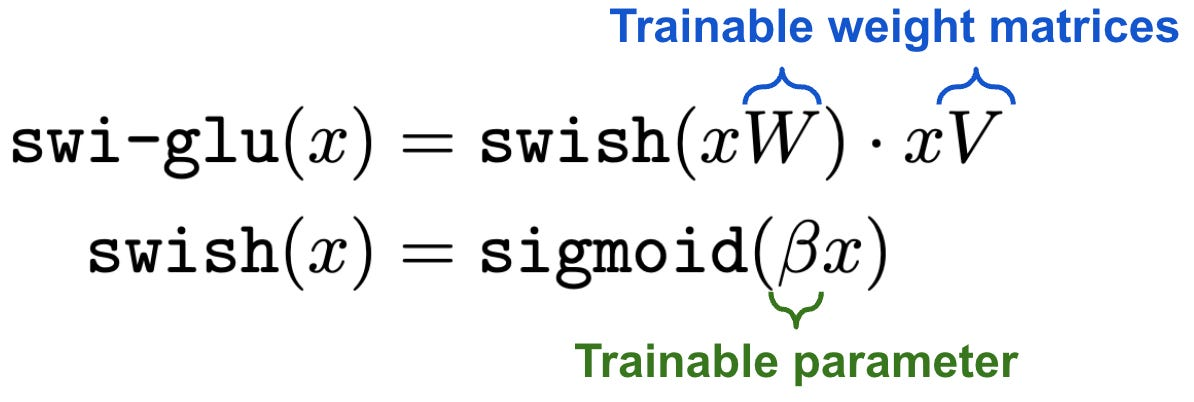

During the forward pass, we increase the dimensionality of the hidden layers to enhance the learning capacity using the Swish-Gated Linear Unit (SwiGLU) activation function. Subsequently, the output is processed through an additional linear layer to reduce the dimensions, ensuring that the final output matches the input dimensions.

In [634]:
class FeedForward(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int, multiple_of: int, ffn_dim_multiplier: Optional[float]):
        super().__init__()
        
        hidden_dim = int(2 * hidden_dim / 3)
        if ffn_dim_multiplier is not None:
            hidden_dim = int(hidden_dim * ffn_dim_multiplier)

        # round of the hidden dim to the next multiple of the multiple_of
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = torch.nn.Linear(dim, hidden_dim, bias = False)
        self.w2 = torch.nn.Linear(hidden_dim, dim, bias = False)
        self.w3 = torch.nn.Linear(dim, hidden_dim, bias = False)

    def forward(self, x):
        return self.w2(F.silu(self.w1(x))* self.w3(x))

# Transformer Block

Now that we have all components for transformer block, We can now create a Transformer block class, which is a basic building block composed of the following elements:

1. **Multi-Head Attention Layer**: This is the attention block which is we created above, input is passed through an RMS norm layer before being passed into the attention layer.

2. **Feed-Forward Network (FFN)**: The output of the transformer layer is passed through an RMS norm layer and then a feed-forward network.

3. **Residual Connections**: Both the attention and feed-forward components of the Transformer Block include residual connections, which allow gradients to flow directly through the network and help mitigate the vanishing gradient problem.


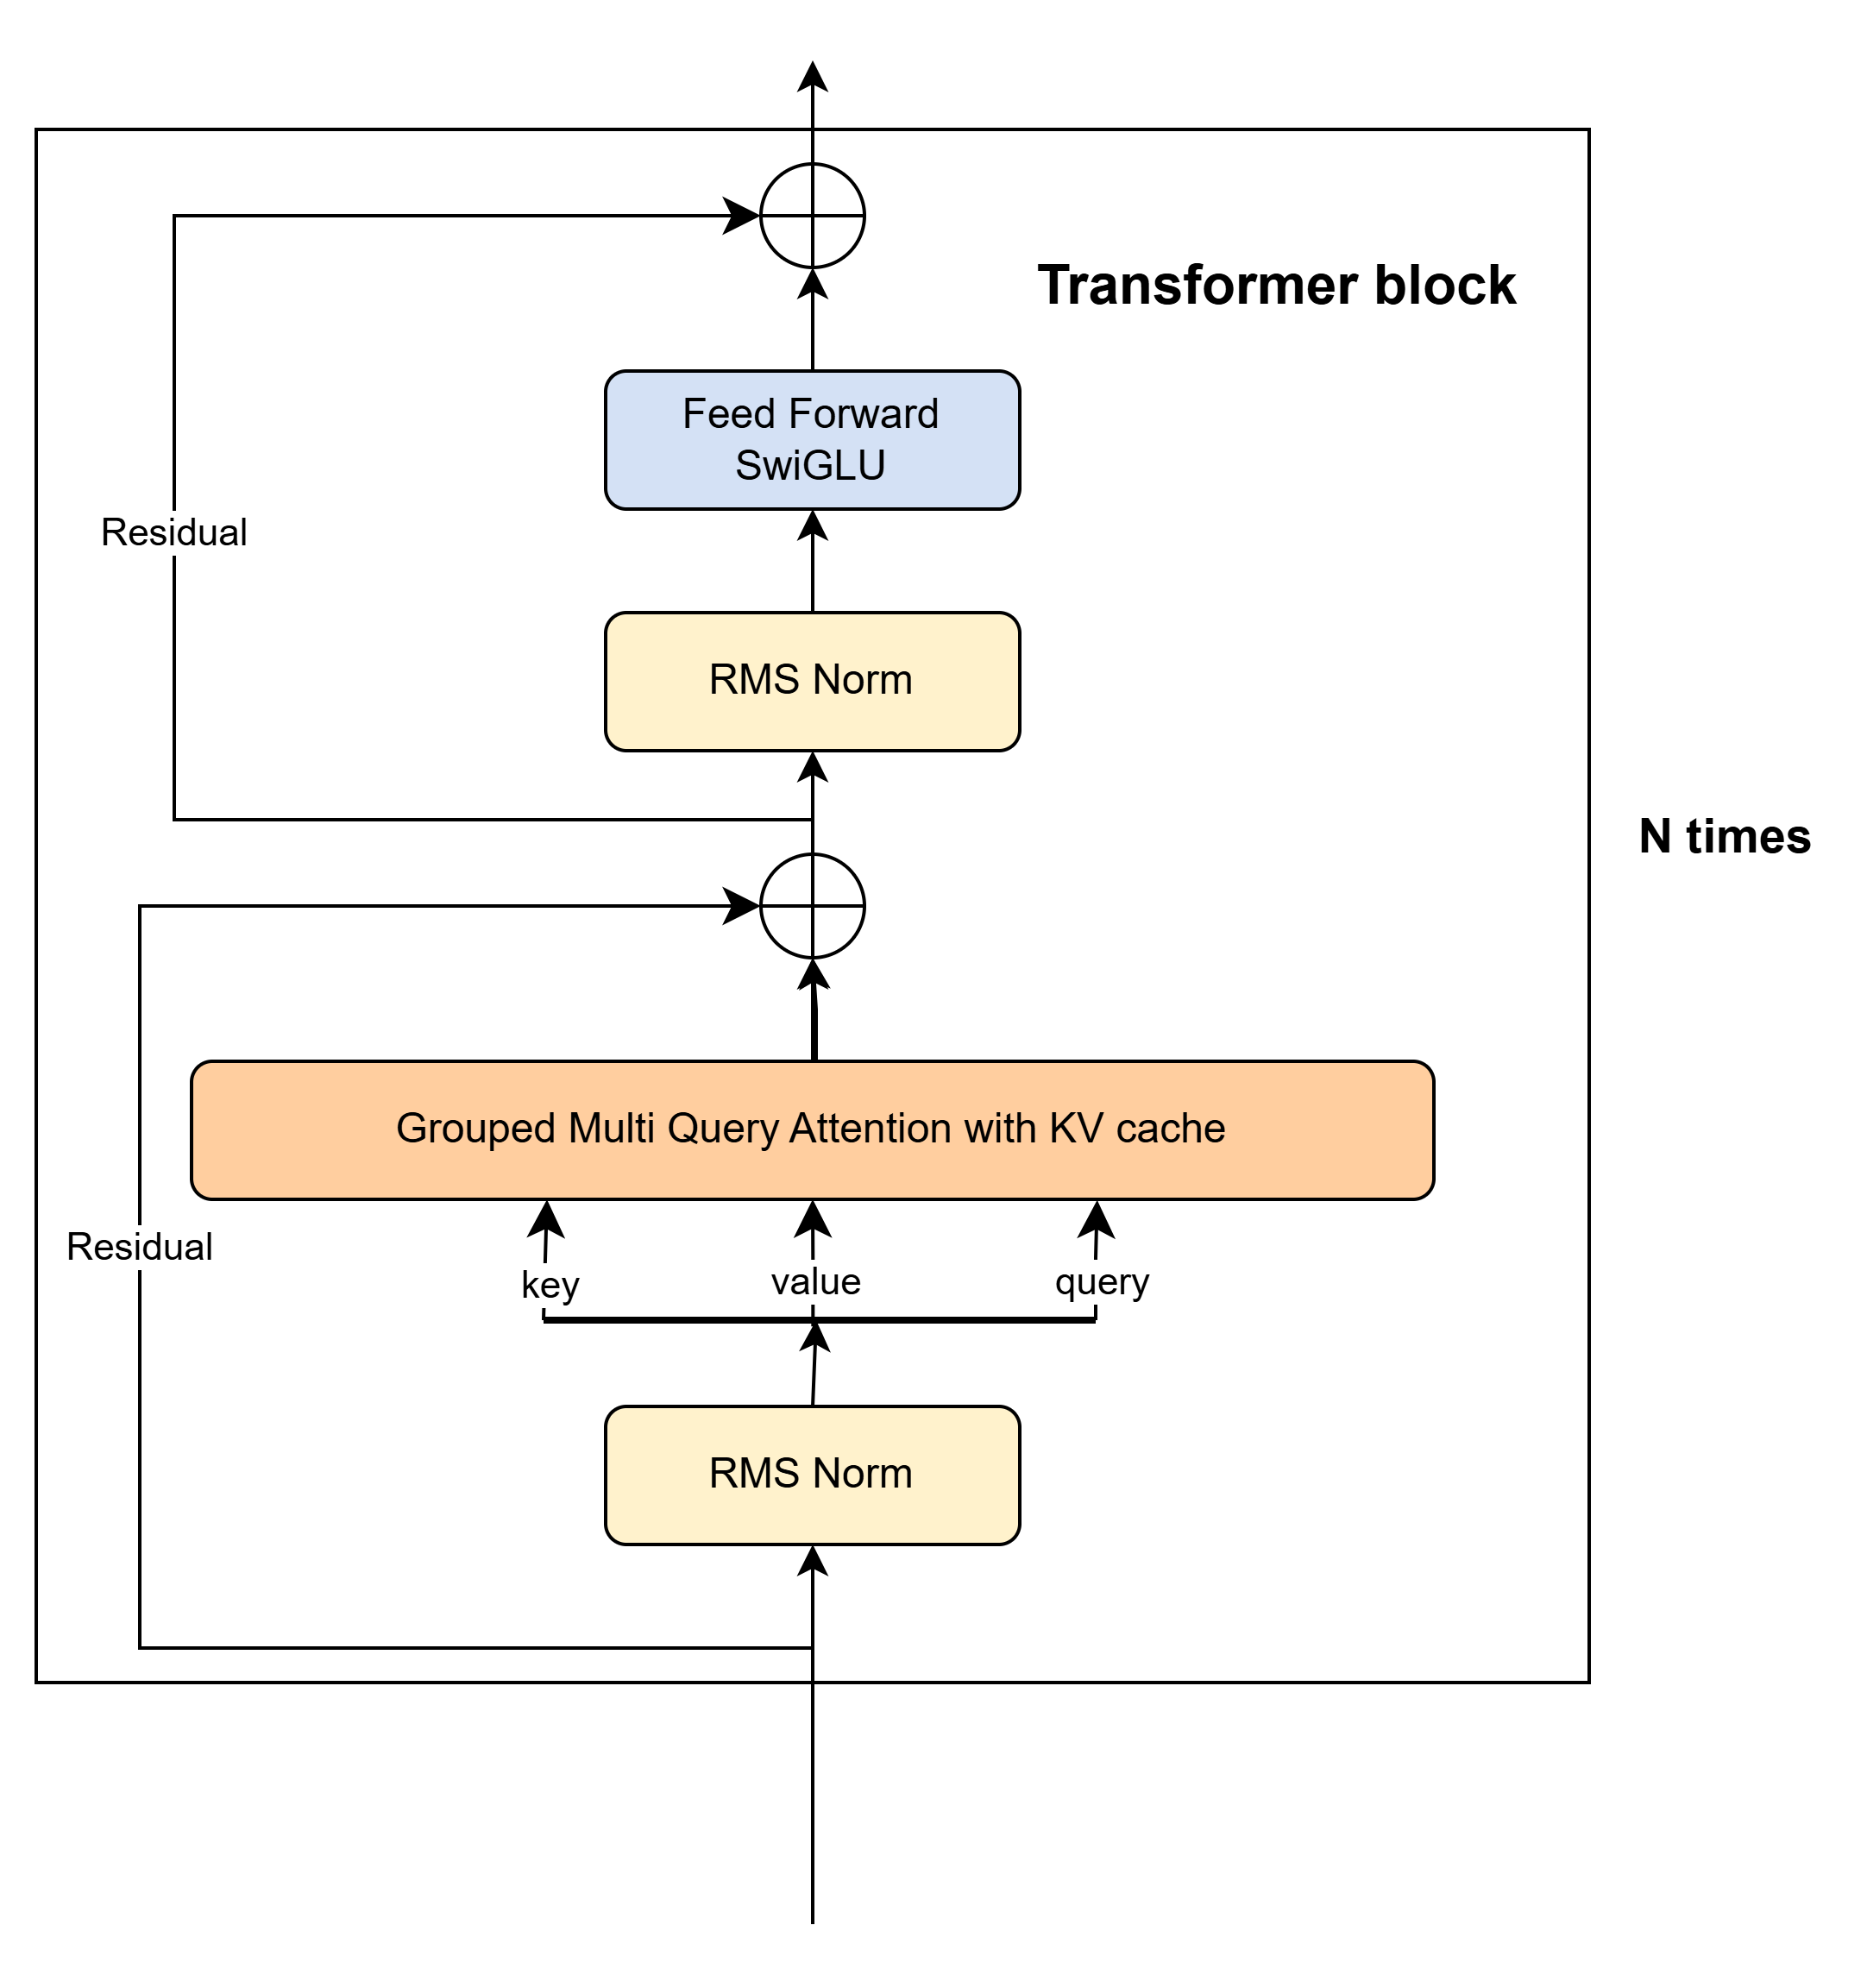

In [635]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.layer_id = layer_id
        self.dim = args.dim
        self.n_heads = args.n_heads
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(args.dim, 4* args.dim, args.multiple_of, args.ffn_dim_multiplier)
        self.attention_norm = RMSNorm(args.dim, args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, args.norm_eps)

    def forward(self, x: torch.Tensor, start_pos: int, freqs_cis: torch.Tensor, mask: Optional[torch.Tensor]):
        h = x + self.attn(self.attention_norm(x), start_pos, freqs_cis, mask)
        output = h + self.feed_forward(self.ffn_norm(h))
        return output

# LlaMA 3 Model

Finally we can create the transformer model, this model has following components:

1. Embedding layer: To convert given tokens to embeddings
2. Then the embedding is passed through 32 transformer block layers
3. The output of transformer block is then passed through a linear layer to get the final output.

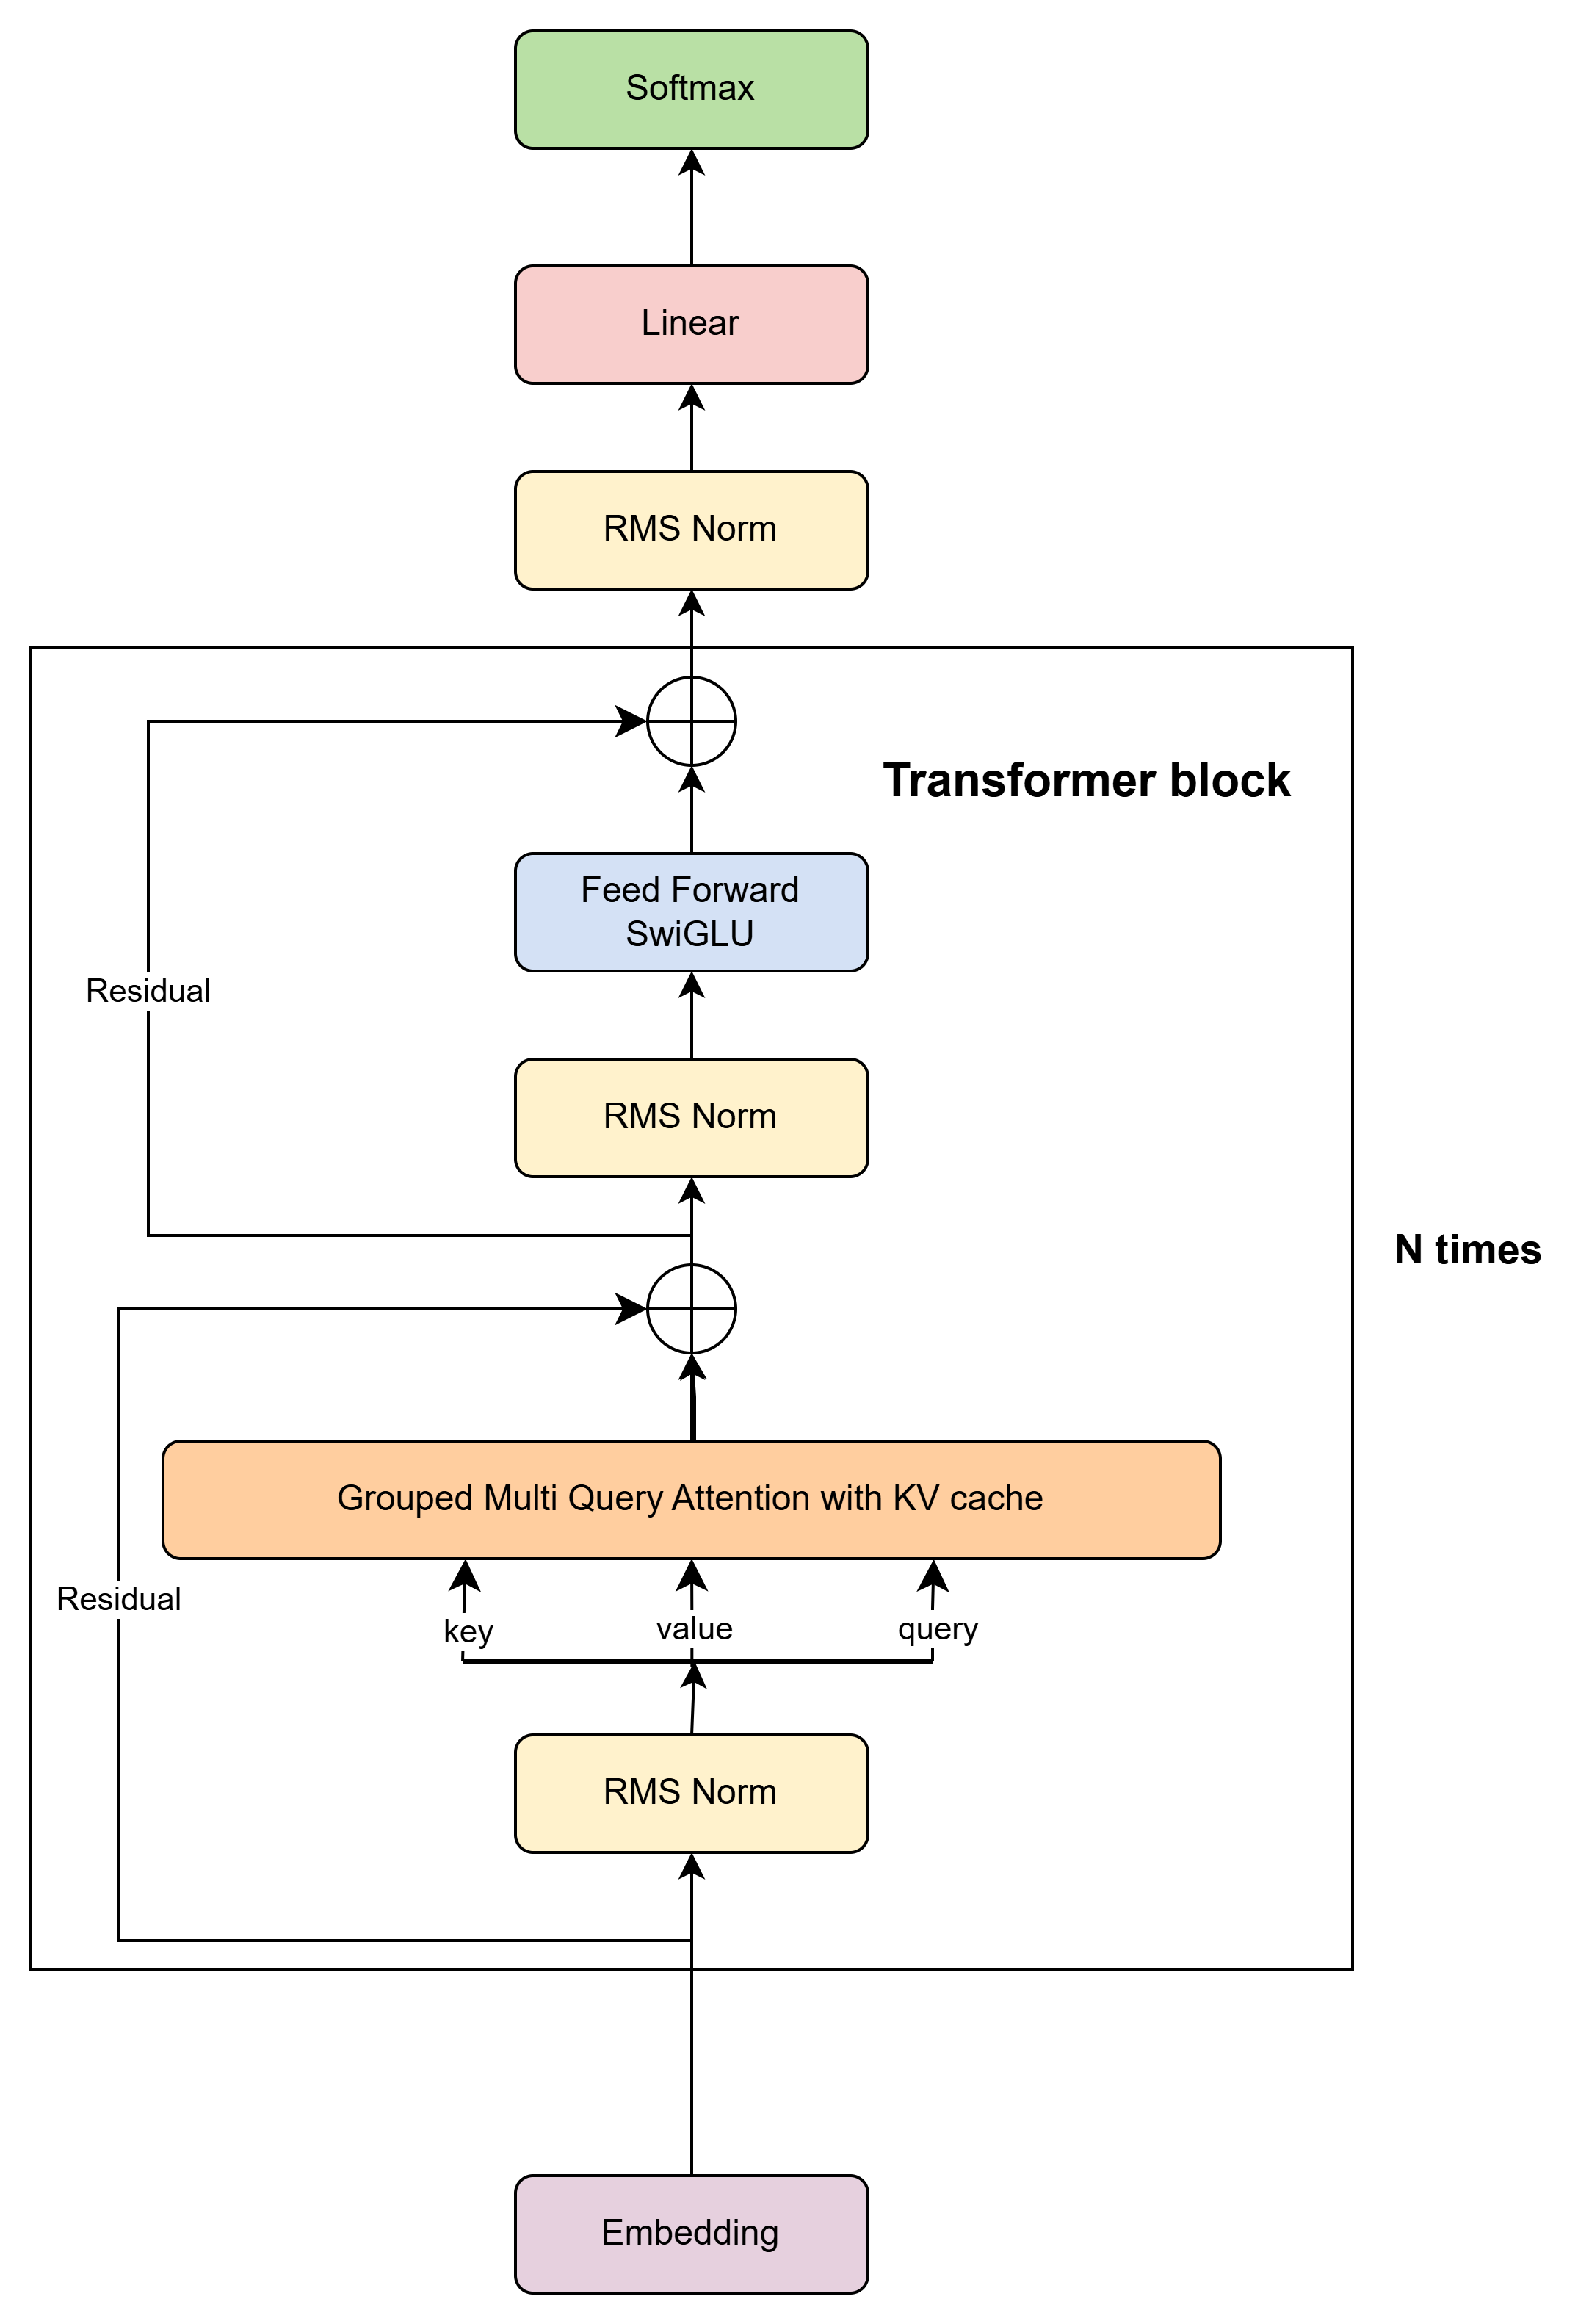

We also pre compute the positional embedding frequencies when creating the model.


In [636]:
class Transformer(torch.nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.params = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = torch.nn.Embedding(args.vocab_size, args.dim)

        self.layers = torch.nn.ModuleList([TransformerBlock(i, args) for i in range(args.n_layers)])
        self.norm = RMSNorm(args.dim, args.norm_eps)
        self.output = torch.nn.Linear(args.dim, args.vocab_size, bias = False)

        self.freqs_cis = precompute_freqs_cis(args.dim // args.n_heads, args.max_seq_len * 2, args.rope_theta)

    @torch.inference_mode()
    def forward(self, tokens: torch.Tensor, start_pos: int):
        batch_size, seq_len = tokens.shape

        x = self.tok_embeddings(tokens)

        mask = None

        if seq_len > 1:
            # create a mask to prevent attention to future tokens
            mask = torch.full((seq_len, seq_len), float("-inf"), device=tokens.device)

            mask = torch.triu(mask, diagonal=1)

            # When performing key-value caching, we compute the attention scores
            # only for the new sequence. Thus, the matrix of scores is of size
            # (seqlen, cache_len + seqlen), and the only masked entries are (i, j) for
            # j > cache_len + i, since row i corresponds to token cache_len + i.
            mask = torch.hstack(
                [torch.zeros((seq_len, start_pos), device=tokens.device), mask]
            ).type_as(x)


        for layer in self.layers:
            x = layer(x, start_pos, self.freqs_cis, mask)

        x = self.norm(x)
        output = self.output(x).float() # (B, Seq, Dim) -> (B, Seq, Vocab)
        return output